In [2]:
from storeSalesUtils.dataloading import load_stores, load_train, load_holidays, load_test, load_oil
from storeSalesUtils.featureEngineering import plot_joint_plot
from storeSalesUtils.modeling import (prophetPipeline, parse_holidays, parse_oil_prophet,
                                      visualize_forecasts, RMSLE, grangers_causation_matrix)

import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pilot model for one store only

## Import modeling libraries

In [3]:
from prophet import Prophet
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

## Useful functions

In [4]:
def setup_prophetData(data, y_col, ds_col):
    if y_col is not None:
        prophetData = data[[ds_col, y_col]].rename({y_col:'y', ds_col:'ds'}, axis=1)
    else:
        prophetData = data[[ds_col]].rename({ds_col:'ds'}, axis=1)
        
    return prophetData

def add_prophetRegressor(data, regressor, ds_col): 
    
    data_with_regressors = pd.merge(data, regressor, on=ds_col)
    
    return data_with_regressors

In [5]:
def RMSLE(y, yhat):
    metric = (np.log(1+yhat) - np.log(1+y))**2
    return round(np.sqrt(metric.mean()), 3)

## Training and validation setup

In [10]:
train = load_train()
stores = load_stores()
holidays = load_holidays()
oil = load_oil()

store_nbr = 36
train = train[train.store_nbr==store_nbr]
train = pd.merge(train, stores, on='store_nbr')

# only use two years of data available
maxDate = train.date.max()
minDate = maxDate - pd.DateOffset(years=2)
print('Using data within the dates: ', maxDate, minDate)
train = train[train.date.between(minDate, maxDate)]

# simulate test set scenario using the last 15 days of data for validation
val_dates = maxDate - pd.DateOffset(15)
train['split'] = np.where(train.date>=val_dates, 'validation', 'train')

train.head()

Using data within the dates:  2017-08-15 00:00:00 2015-08-15 00:00:00


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,split
31482,1700985,2015-08-15,36,AUTOMOTIVE,6.0,0,Libertad,Guayas,E,10,train
31483,1700986,2015-08-15,36,BABY CARE,0.0,0,Libertad,Guayas,E,10,train
31484,1700987,2015-08-15,36,BEAUTY,2.0,0,Libertad,Guayas,E,10,train
31485,1700988,2015-08-15,36,BEVERAGES,2340.0,3,Libertad,Guayas,E,10,train
31486,1700989,2015-08-15,36,BOOKS,0.0,0,Libertad,Guayas,E,10,train


In [11]:
fam = 'BEAUTY'
train_fam = train[train.family==fam]

In [12]:
train_fam.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,split
31484,1700987,2015-08-15,36,BEAUTY,2.0,0,Libertad,Guayas,E,10,train
31517,1702769,2015-08-16,36,BEAUTY,2.0,0,Libertad,Guayas,E,10,train
31550,1704551,2015-08-17,36,BEAUTY,1.0,0,Libertad,Guayas,E,10,train
31583,1706333,2015-08-18,36,BEAUTY,1.0,0,Libertad,Guayas,E,10,train
31616,1708115,2015-08-19,36,BEAUTY,0.0,0,Libertad,Guayas,E,10,train


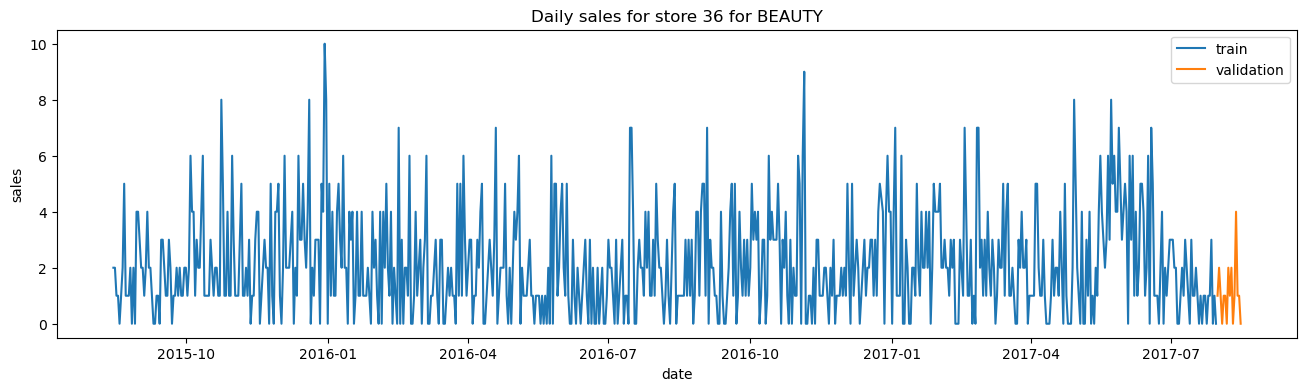

In [13]:
train_df = train_fam[train_fam.split=='train']
val_df = train_fam[train_fam.split=='validation']

fig, ax = plt.subplots()
sns.lineplot(train_df, x='date', y='sales', ax=ax, label='train')
sns.lineplot(val_df, x='date', y='sales', ax=ax, label='validation')
plt.title(f'Daily sales for store {store_nbr} for {fam}')
plt.show()

In [14]:
oil_prophet = setup_prophetData(oil, 'dcoilwtico', 'date').rename({'y':'dcoilwtico'}, axis=1)
oil_prophet = oil_prophet.set_index('ds').resample('d')
oil_prophet = oil_prophet.fillna(method='nearest').fillna(method='bfill').reset_index()
oil_prophet.head()

,ds,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


In [15]:
oil_prophet.ds.describe(datetime_is_numeric=True)

count                             1704
mean     2015-05-02 11:59:59.999999744
min                2013-01-01 00:00:00
25%                2014-03-02 18:00:00
50%                2015-05-02 12:00:00
75%                2016-07-01 06:00:00
max                2017-08-31 00:00:00
Name: ds, dtype: object

In [16]:
oil_prophet.isnull().sum()

ds            0
dcoilwtico    0
dtype: int64

In [18]:
prophet_df = setup_prophetData(train_fam, 'sales', 'date')
prophet_df = add_prophetRegressor(prophet_df, oil_prophet, 'ds')
prophet_df = pd.merge(prophet_df, train_fam[['date', 'onpromotion', 'split']], left_on='ds',
                      right_on='date').drop('date', 1)
prophet_df

,ds,y,dcoilwtico,onpromotion,split
0,2015-08-15,2.0,42.45,0,train
1,2015-08-16,2.0,41.93,0,train
2,2015-08-17,1.0,41.93,0,train
3,2015-08-18,1.0,42.58,0,train
4,2015-08-19,0.0,40.75,0,train
...,...,...,...,...,...
725,2017-08-11,1.0,48.81,0,validation
726,2017-08-12,4.0,48.81,2,validation
727,2017-08-13,1.0,47.59,0,validation
728,2017-08-14,1.0,47.59,0,validation


In [20]:
# we have reasons to believe that price of oil somehow might affect the sales
grangers_causation_matrix(prophet_df, ['y', 'dcoilwtico', 'onpromotion'], maxlag=14, test='ssr_chi2test')

,y_x,dcoilwtico_x,onpromotion_x
y_y,1.0000,0.5949,0.0378
dcoilwtico_y,0.1950,1.0000,0.4163
onpromotion_y,0.0276,0.0011,1.0000


In [21]:
relevant_holidays = holidays[holidays.locale_name.isin(['Ecuador', train_fam.city.unique()[0], train_fam.state.unique()[0]])]
relevant_holidays = relevant_holidays[['date', 'description']]
relevant_holidays.columns = ['ds', 'holiday']
earthquake = {'ds':pd.to_datetime('2016-04-16'), 'holiday':'Earthquake'}
relevant_holidays = relevant_holidays.append(earthquake, ignore_index=True)
relevant_holidays.sort_values('ds', inplace=True)

# further cleaning should be done here, "traslados" holidays might be problematic but lets just proceed like this
relevant_holidays.head()

,ds,holiday
0,2012-04-14,Cantonizacion de Libertad
1,2012-08-10,Primer Grito de Independencia
2,2012-10-09,Independencia de Guayaquil
3,2012-10-12,Traslado Independencia de Guayaquil
4,2012-11-02,Dia de Difuntos


### Train Prophet model

In [24]:
def train_prophet(prophet_df, holidays=None, regressor_list=None):
    
    if regressor_list is None:
        regressor_list = []
    
    train_df = prophet_df[prophet_df.split=='train'].drop('split', 1)
    val_df = prophet_df[prophet_df.split=='validation'].drop('split', 1)
    
    # first fit a model to the train data
    m = Prophet(growth='linear', holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    if len(regressor_list)>0:
        for name in regressor_list:
            m.add_regressor(name)
    m.fit(train_df)
    
    # assess fit on the validation set
    forecast = m.predict(prophet_df)
    forecast = pd.merge(forecast, prophet_df[['ds', 'y', 'split']], on='ds')

    return m, forecast

In [25]:
m, forecast = train_prophet(prophet_df, relevant_holidays, ['dcoilwtico', 'onpromotion'])

19:57:31 - cmdstanpy - INFO - Chain [1] start processing
19:57:31 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot: xlabel='dayOfMonth', ylabel='y'>

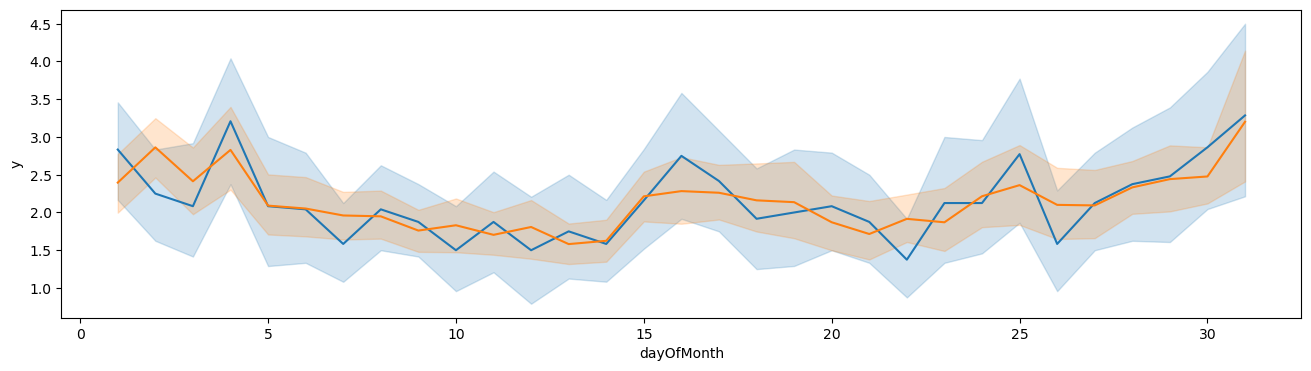

In [26]:
forecast['dayOfMonth'] = forecast.ds.dt.day

sns.lineplot(forecast, x='dayOfMonth', y='y')
sns.lineplot(forecast, x='dayOfMonth', y='yhat')

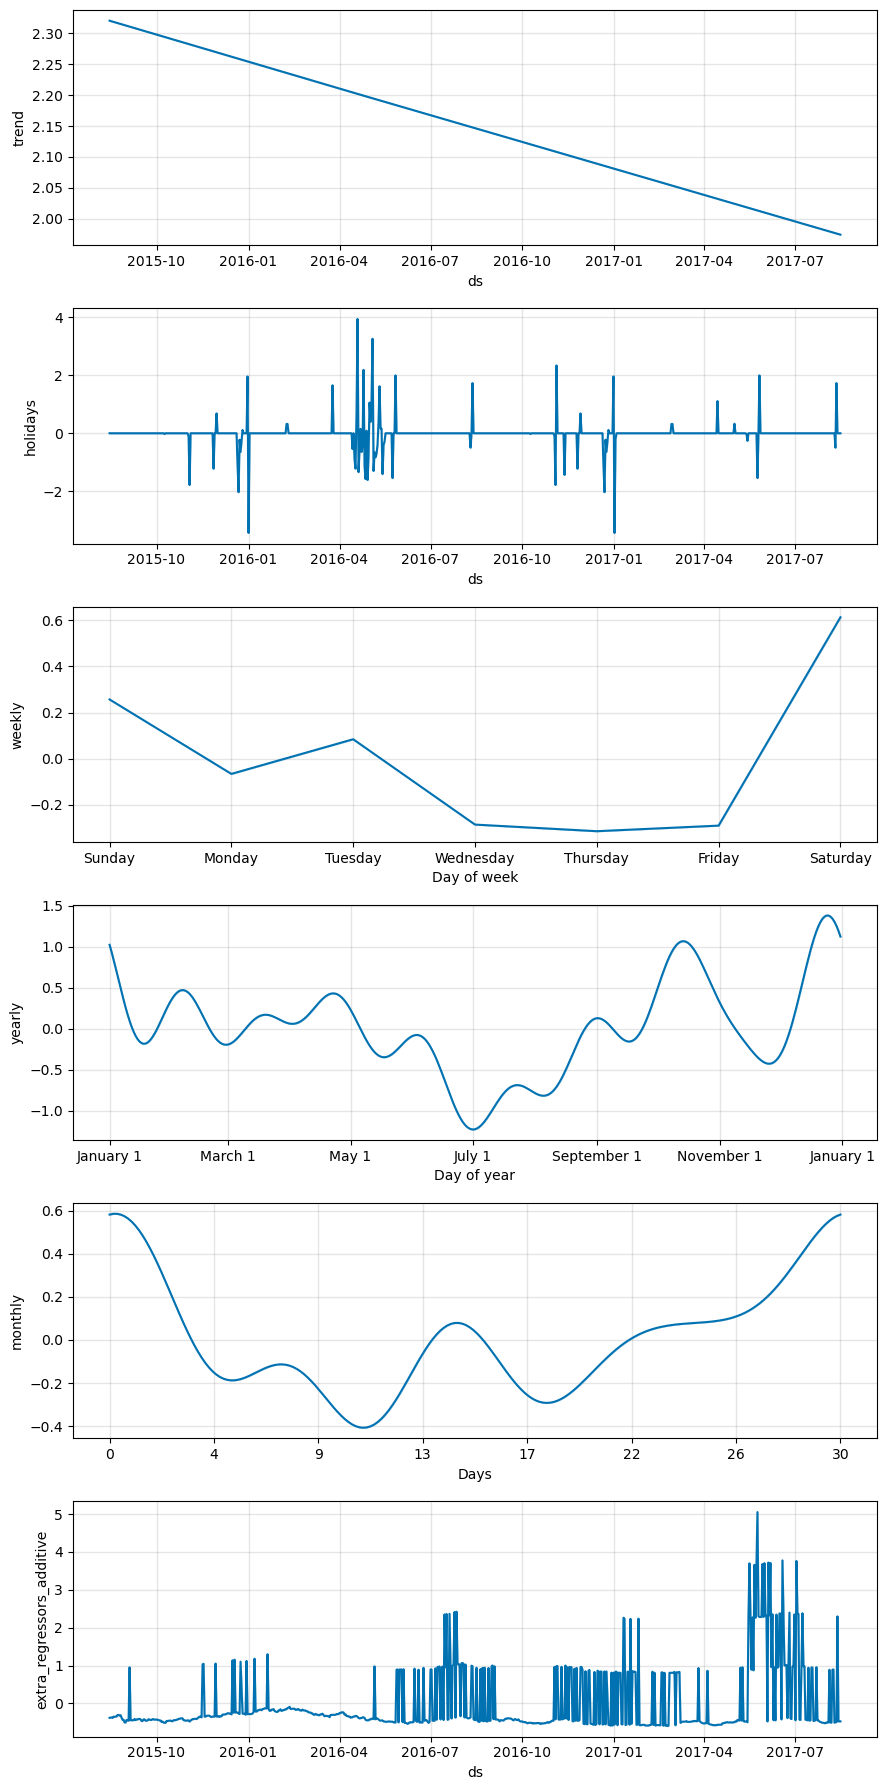

In [27]:
m.plot_components(forecast)
plt.show()

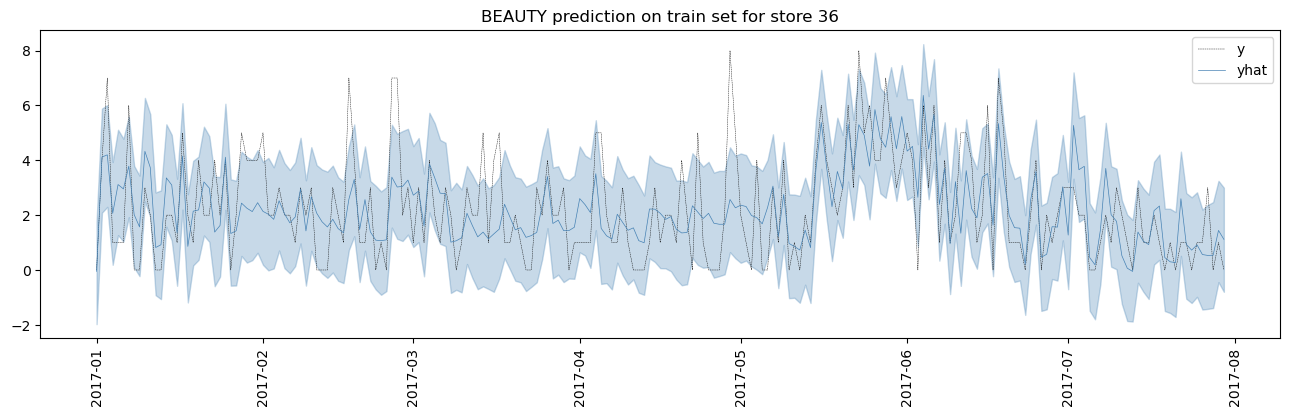

In [28]:
val_df = forecast[forecast.split=='train']
val_df = val_df[val_df.ds>=pd.to_datetime('2017-01-01')]
val_error = RMSLE(val_df.y, val_df.yhat)

f, ax = plt.subplots()

ax.plot(val_df.ds, val_df.y, '--k', markersize=1, lw=0.3, label='y')
ax.plot(val_df.ds, val_df.yhat, '-', markersize=1, color='steelblue', lw=0.5, label='yhat')

ax.fill_between(val_df.ds, val_df.yhat_lower, val_df.yhat_upper, color='steelblue', alpha=0.3)
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=90)
plt.title(f'{fam} prediction on train set for store {store_nbr}')
# plt.text(0.01, 0.9, 'Validation RMSLE: %.03f' %val_error, transform=ax.transAxes)

plt.legend()
# plt.grid()
plt.show()

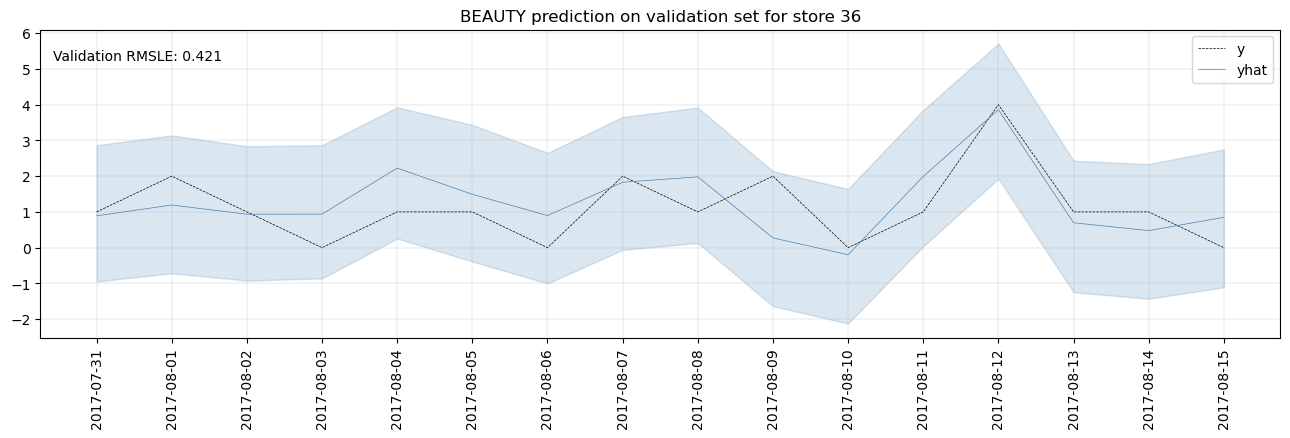

In [29]:
val_df = forecast[forecast.split=='validation']
val_error = RMSLE(val_df.y, val_df.yhat)

f, ax = plt.subplots()

ax.plot(val_df.ds, val_df.y, '--k', markersize=1, lw=0.5, label='y')
ax.plot(val_df.ds, val_df.yhat, '-', markersize=1, color='steelblue', lw=0.5, label='yhat')

ax.fill_between(val_df.ds, val_df.yhat_lower, val_df.yhat_upper, color='steelblue', alpha=0.2)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=90)
plt.title(f'{fam} prediction on validation set for store {store_nbr}')
plt.text(0.01, 0.9, 'Validation RMSLE: %.03f' %val_error, transform=ax.transAxes)

plt.legend()
plt.grid(linewidth=0.2)
plt.show()

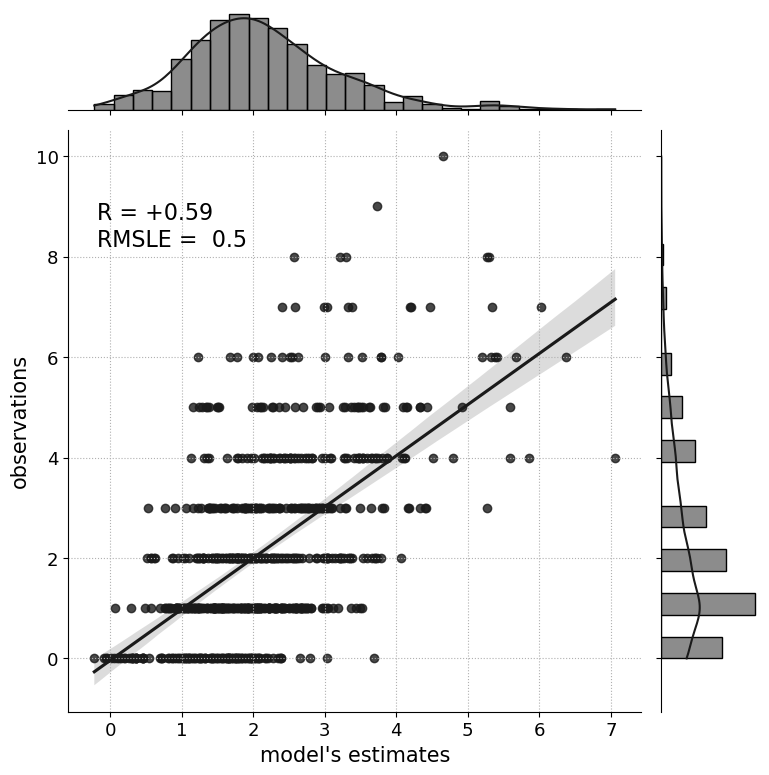

In [30]:
plot_joint_plot(forecast[forecast.split=='train'])

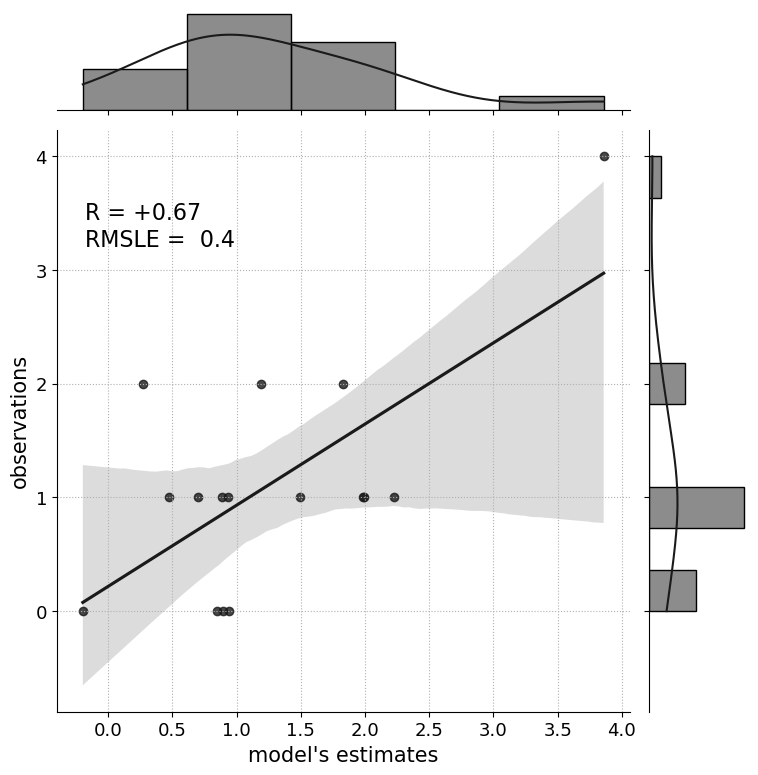

In [31]:
plot_joint_plot(forecast[forecast.split=='validation'])

## Test set

In [28]:
test = load_test()
test = test[test.store_nbr==store_nbr]
test = pd.merge(test, stores, on='store_nbr')

In [198]:
test_fam = test[(test.store_nbr==store_nbr) & (test.family==fam)]

test_fam.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3001845,2017-08-16,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
33,3003627,2017-08-17,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
66,3005409,2017-08-18,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
99,3007191,2017-08-19,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
132,3008973,2017-08-20,36,AUTOMOTIVE,0,Libertad,Guayas,E,10


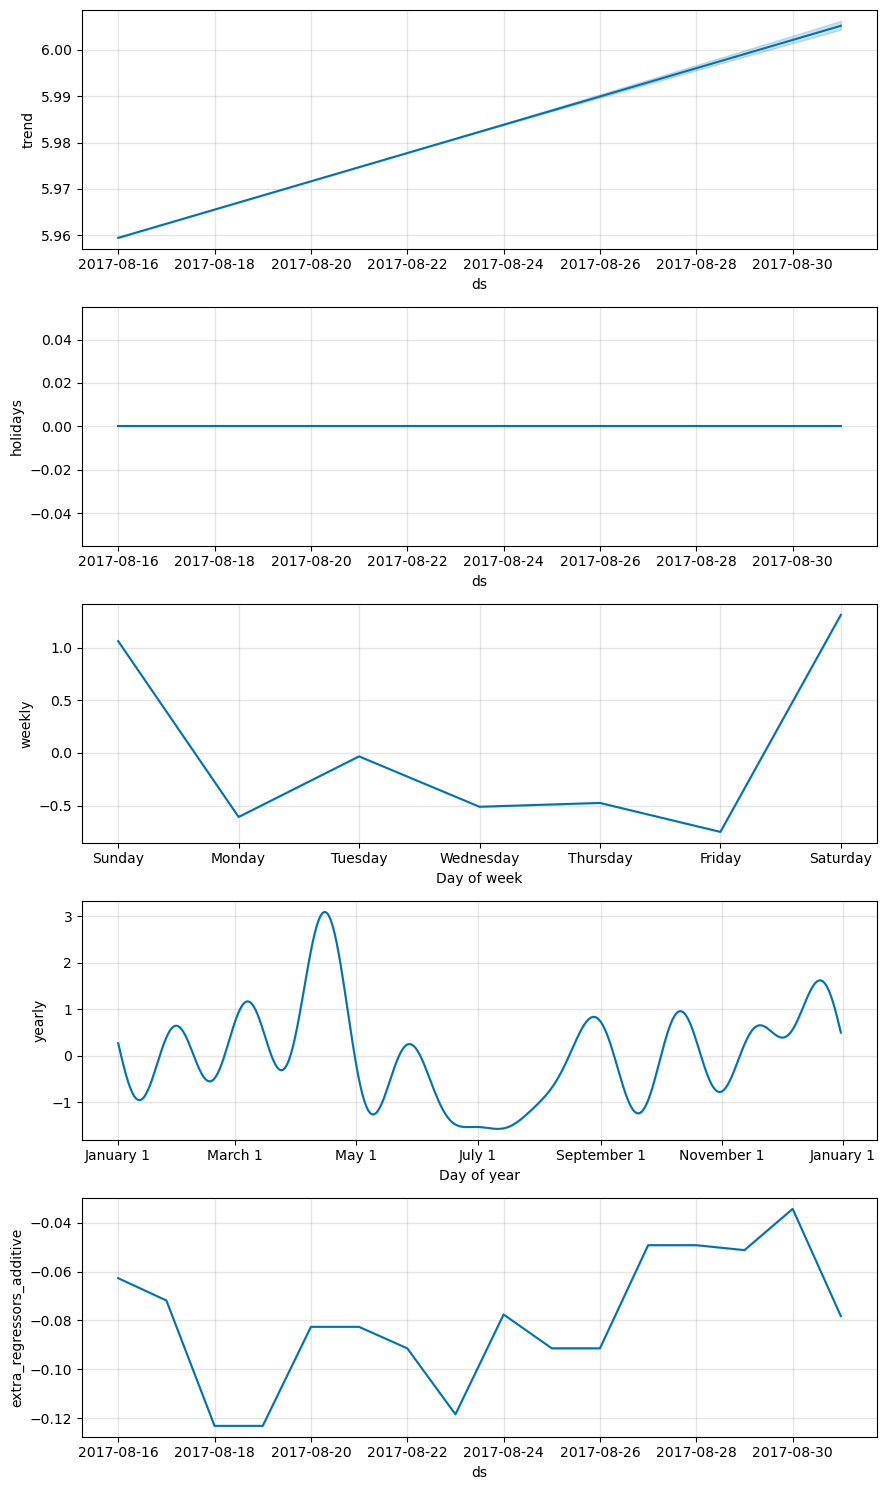

In [208]:
prophet_df = setup_prophetData(test_fam, None, 'date')
prophet_df = add_prophetRegressor(prophet_df, oil_prophet, 'ds')

test_forecast = m.predict(prophet_df)
m.plot_components(test_forecast)
plt.show()

In [221]:
prediction = test_forecast[['ds', 'yhat']].rename(mapper={'ds':'date', 'yhat':'sales'}, axis=1)
prediction = pd.merge(prediction, test_fam, on='date')
prediction

,date,sales,id,store_nbr,family,onpromotion,city,state,type,cluster
0,2017-08-16,5.368536,3001845,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
1,2017-08-17,5.494128,3003627,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
2,2017-08-18,5.266696,3005409,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
3,2017-08-19,7.428374,3007191,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
4,2017-08-20,7.315361,3008973,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
5,2017-08-21,5.736207,3010755,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
6,2017-08-22,6.390772,3012537,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
7,2017-08-23,5.964670,3014319,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
8,2017-08-24,6.112905,3016101,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
9,2017-08-25,5.884235,3017883,36,AUTOMOTIVE,0,Libertad,Guayas,E,10
